In [1]:
from IPython.display import HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
from shapely.geometry import Point

import sys
sys.path.insert(0, '../src/processing/')
import tools
import os.path
import definitions

## Introduction <a name="introduction"></a>
With the large volume of CTA bus location data I have collected so far in 2019, I want to develop a process for analyzing the data on a neighborhood and city level. My aim is to measure and compare the quality of bus service within each [Chicago community area](https://en.wikipedia.org/wiki/Community_areas_in_Chicago). In this notebook, I begin to develop a process for neighborhood-level analysis by working with data for the bus routes that service Logan Square, specifically restricting my analysis to the geopositional data and bus stops within the boundaries of the neighborhood. To start, I estimate the average wait times for each bus route servicing Logan Square, as well as the proportion of the trips on each route that experience [bus bunching](https://en.wikipedia.org/wiki/Bus_bunching) in the neighborhood.

Logan Square is served by the following bus routes:
* 49 Western 
* X49 Western Express
* 52 Kedzie/California
* 53 Pulaski
* 56 Milwaukee
* 73 Armitage
* 74 Fullerton
* 76 Diversey
* 82 Kimball-Homan

I use data from 73 Armitage to develop the initial data processing workflow and then combine the code into reusable functions.

### Load geospatial data for Chicago's community area boundaries into a `GeoDataFrame`
The geospatial boundaries of Chicago's 77 community areas can be found at the [Chicago Data Portal](https://data.cityofchicago.org/). 

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,(POLYGON ((-87.60914087617894 41.8446925026539...
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,(POLYGON ((-87.59215283879394 41.8169293462668...
2,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,(POLYGON ((-87.62879823733725 41.8018930336891...
3,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,(POLYGON ((-87.6067081256125 41.81681377057218...
4,KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062,(POLYGON ((-87.59215283879394 41.8169293462668...


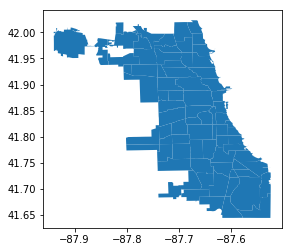

In [2]:
commareas = gpd.read_file("../data/raw/geofences/Boundaries - Community Areas (current).geojson")
commareas.plot()
commareas.head()

I'm only concerned about the boundaries of Logan Square for the rest of the notebook.

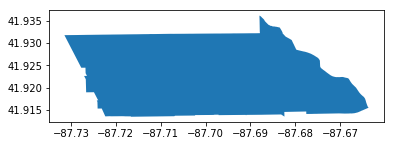

In [3]:
losq = commareas[commareas.community == "LOGAN SQUARE"]
losq.plot()

### Load the bus patterns into a `GeoDataFrame`
I load pattern data for Route 73 Armitage, which details the locations of each of its bus stops. The plan is to identify only those bus stops which are in Logan Square by performing a spatial join on this data set with `losq`. Since the raw pattern data is not stored in a geospatial file format---they are regular JSON files---I cannot directly load it into a `GeoDataFrame`. I first load it into a regular `DataFrame`, then create geometry objects using the latitude and longitudes columns, and finally load the `DataFrame` and geometry into a `GeoDataFrame`.

In [4]:
patterns = tools.load_patterns(73, False)
patterns.head()

,lat,lon,pdist,seq,stpid,stpnm,typ,ln,pid,rtdir
0,41.913547,-87.633030,287.0,4,1451,Clark & Lasalle,S,36853.0,2169,Westbound
1,41.915565,-87.634193,1024.0,6,1905,Clark & Lincoln,S,36853.0,2169,Westbound
2,41.916687,-87.634905,1470.0,8,1906,Clark & Wisconsin,S,36853.0,2169,Westbound
3,41.918220,-87.636368,2359.0,14,13180,Armitage & Clark,S,36853.0,2169,Westbound
4,41.918212,-87.639118,3097.0,17,4084,Armitage & Lincoln/Sedgwick,S,36853.0,2169,Westbound


,lat,lon,pdist,seq,stpid,stpnm,typ,ln,pid,rtdir,geometry
0,41.913547,-87.633030,287.0,4,1451,Clark & Lasalle,S,36853.0,2169,Westbound,POINT (-87.633029999999 41.913547)
1,41.915565,-87.634193,1024.0,6,1905,Clark & Lincoln,S,36853.0,2169,Westbound,POINT (-87.634193000002 41.915564999999)
2,41.916687,-87.634905,1470.0,8,1906,Clark & Wisconsin,S,36853.0,2169,Westbound,POINT (-87.634904999998 41.916687)
3,41.918220,-87.636368,2359.0,14,13180,Armitage & Clark,S,36853.0,2169,Westbound,POINT (-87.63636800000199 41.918219999999)
4,41.918212,-87.639118,3097.0,17,4084,Armitage & Lincoln/Sedgwick,S,36853.0,2169,Westbound,POINT (-87.63911799999801 41.918212000001)


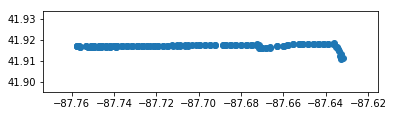

In [5]:
geometry = [Point(xy) for xy in zip(patterns.lon, patterns.lat)]
patterns_gdf = gpd.GeoDataFrame(patterns, geometry=geometry, crs={'init': 'epsg:4326'})
patterns_gdf.plot()
patterns_gdf.head()

### Perform a spatial join on the two geometry objects
Intersect the bus stop geometry (Points) with the neighborhood geometry (Polygon) to select only those bus stops in Logan Square.

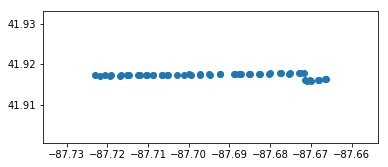

In [6]:
losq_stops = gpd.sjoin(patterns_gdf, losq, how="inner", op="intersects")
losq_stops.plot()

### Load the travel and wait times into a `DataFrame`
I load the travel and wait times data for Route 73 Armitage (and abitrarily choose to just work with the data for westbound trips in January for now).

In [7]:
travels_waits = tools.load_travels_waits(73, "Westbound", "201901")
travels_waits.head()

,1451,1905,1906,13180,4084,4085,4086,4087,4088,4089,...,4137,4138,3883,14179,start_date,pid,tatripid,decimal_time,wait|14179,origin
0,NaN,0.52,0.85,1.60,2.53,2.85,3.30,3.77,4.28,4.87,...,33.48,34.22,34.98,35.15,2019-01-01,2169,2,7.05,49.65,1451
1,NaN,0.42,0.77,1.32,1.80,2.33,3.02,3.43,3.90,4.53,...,27.63,28.23,NaN,NaN,2019-01-01,2169,8,7.87,14.37,1451
2,NaN,0.72,1.00,2.17,3.57,3.97,4.52,5.05,6.32,7.92,...,33.40,34.17,34.92,35.07,2019-01-01,2169,9,8.12,20.97,1451
3,NaN,0.63,1.02,1.75,2.27,2.70,3.30,3.83,4.40,5.10,...,32.50,32.90,33.47,33.75,2019-01-01,2169,10,8.47,23.68,1451
4,NaN,0.20,0.38,0.82,1.37,1.73,2.17,2.55,3.10,4.12,...,28.75,29.62,37.27,37.45,2019-01-01,2169,14,8.85,25.22,1451


Because bus service varies throughout the day, it makes sense to analyze bus service during different time intervals. The CTA defines four weekday service intervals in its [Service Standards and Policies](https://www.transitchicago.com/assets/1/6/Service_standards_FINAL_20140306.pdf) document:
* AM Peak: 6AM-9AM
* Midday: 9AM-3PM
* PM Peak: 3PM-6PM
* Evening: 7PM-10PM

I also go ahead and drop all of the rows where the origin bus stop is not within Logan Square.

In [8]:
cta_time_periods = [6, 9, 15, 19, 22]
cta_time_period_labels = ["AM Peak", "Midday", "PM Peak", "Evening"]

travels_waits["bins"] = pd.cut(travels_waits.decimal_time, cta_time_periods, labels=cta_time_period_labels, right=False)
travels_waits.drop(travels_waits[~travels_waits.origin.isin(losq_stops.stpid)].index, inplace=True)
travels_waits.head()

,1451,1905,1906,13180,4084,4085,4086,4087,4088,4089,...,4138,3883,14179,start_date,pid,tatripid,decimal_time,wait|14179,origin,bins
27526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24.07,24.83,25.00,2019-01-01,2169,2,7.22,19.72,4095,AM Peak
27527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.62,20.47,20.72,2019-01-01,2169,7,7.53,28.32,4095,AM Peak
27528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.70,NaN,NaN,2019-01-01,2169,8,8.02,18.57,4095,AM Peak
27529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.43,22.18,22.33,2019-01-01,2169,9,8.32,17.25,4095,AM Peak
27530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.88,24.45,24.73,2019-01-01,2169,10,8.62,22.60,4095,AM Peak


### Calculate the average wait time for an Armitage bus in Logan Square (by direction of travel and time of day)
As a bus completes its route, the wait time between it and the next bus will vary from stop to stop. First, I find the average wait time at the Logan Square bus stops for each Armitage bus trip. Then I average over those averages to find the average wait time for the Armitage bus in Logan Square. As explained in the documentation, each trip is uniquely identified by its "start_date", "pid", and "tatripid". I further aggregate the data by time of day.

Note: For each departure from an origin stop, the travels_waits `DataFrame` gives the wait time (in minutes) for the next bus arrival heading to a particular terminal stop. Since some routes have more than one terminus, there may be more than one calculated wait time. Each column "wait|STPID_1", ..., "wait|STPID_N" gives the wait time for the next bus heading to some terminal with `stpid` STPID_M.

In [9]:
terminals = travels_waits.columns[travels_waits.columns.str.contains("wait\|")]
trip_means = travels_waits.groupby(["start_date", "pid", "tatripid", "bins"])[terminals].mean().reset_index()

The travels_waits data files are already separated by direction of travel. Explicitly naming and grouping by the direction of travel is just for convenience when reading the printed output.

In [10]:
trip_means["rtdir"] = "Westbound"
trip_means.groupby(["rtdir", "bins"])[terminals].mean()
print trip_means.groupby(["rtdir", "bins"])[terminals].mean()

                   wait|14179
rtdir     bins               
Westbound AM Peak   13.886208
          Midday    16.265976
          PM Peak   14.409311
          Evening   21.294015


As expected, the morning and evening rush service has the shortest wait times, while service in the later evening has the longest wait times. The Armitage bus is classified as a "Support Route" by the CTA, so it has longer wait times and a narrower window of service than "Key Routes" like Route 74 Fullerton.

### Calculate the proportion of bunched trips 
To find the proportion of trips that were "bunched", first count the number of bunching incidents during each time interval, then countx the total number of trips during each time interval, and divide the two results. 

I arbitrarily classify any trip as bunched if the wait time between it and the next bus (heading toward or through the same terminal stop) is less than 2 minutes. In the future, I could define bus bunching in a more nuanced way--such as defining the bunching threshold in terms of the route's scheduled wait times--but this definition works for a first-round exploration and analysis.

In [11]:
# bunching incidents
masked = trip_means.copy()
masked[terminals] = (masked[terminals] < 2)
masked.groupby(["rtdir", "bins"])[terminals].sum()

wait|14179
rtdir     bins               
Westbound AM Peak         4.0
          Midday          3.0
          PM Peak         6.0
          Evening         0.0

In [12]:
# total number of trips
trip_means.groupby(["rtdir", "bins"])[terminals].count()

wait|14179
rtdir     bins               
Westbound AM Peak         402
          Midday          738
          PM Peak         568
          Evening         223

In [13]:
# proportion of trips that were bunched
masked.groupby(["rtdir", "bins"])[terminals].sum() / trip_means.groupby(["rtdir", "bins"])[terminals].count()

wait|14179
rtdir     bins               
Westbound AM Peak    0.009950
          Midday     0.004065
          PM Peak    0.010563
          Evening    0.000000

Route 73 experiences very little bus bunching under my definition. This shouldn't be surprising: the headways throughout the day on Route 73 are all over 13 minutes on average.

### Combine the above code to process all Logan Square bus routes

In [14]:
# Travels/waits data files are separated by route and month
dates = [
    "201901",
    "201902",
    "201903",
    "201904",
]

# Bus routes going through Logan Square
rts = ["49","X49","52","53","56","73","74","76","82"]

cta_holidays = pd.DatetimeIndex(definitions.HOLIDAYS)
cta_time_periods = [6,9,15,19,22]
cta_time_period_labels = ["AM Peak", "Midday", "PM Peak", "Evening"]

def load_community_area(path, ca):
    commareas = gpd.read_file(path)
    return commareas[commareas.community == ca.upper()]
    
def patterns_to_gdf(rt, waypoints):
    patterns = tools.load_patterns(rt, waypoints)
    geometry = [Point(xy) for xy in zip(patterns.lon, patterns.lat)]
    return gpd.GeoDataFrame(patterns, geometry=geometry, crs={'init': 'epsg:4326'})

In [15]:
losq_mean_waits = []
losq_bunching = []

losq = load_community_area("../data/raw/geofences/Boundaries - Community Areas (current).geojson", "LOGAN SQUARE")
for rt in rts:
    patterns_gdf = patterns_to_gdf(rt, False)
    losq_stops = gpd.sjoin(patterns_gdf, losq, how="inner", op="intersects")

    colname_map = {"wait|{}".format(stpid): stpnm for stpid, stpnm in zip(patterns_gdf.stpid, patterns_gdf.stpnm)}
    for rtdir in losq_stops.rtdir.unique():      
        tws = pd.concat((tools.load_travels_waits(rt, rtdir.lower(), d) for d in dates), ignore_index=True)

        # I further restrict the analysis to non-holiday weekdays,
        # since frequency of service is different on holidays and weekends
        tws.drop(tws[(tws.start_date.dt.dayofweek >= 5) | tws.start_date.isin(cta_holidays)].index, inplace=True)
        tws.drop(tws[~tws.origin.isin(losq_stops.stpid)].index, inplace=True)
        tws.dropna(axis='columns', how='all', inplace=True)

        terminals = [colname_map[col] for col in tws.columns[tws.columns.str.contains("wait\|")]]
        tws.rename(columns=colname_map, inplace=True)

        tws["bins"] = pd.cut(tws.decimal_time, cta_time_periods, labels=cta_time_period_labels, right=False)

        rt_waits = tws.groupby(["start_date", "pid", "tatripid", "bins"])[terminals].mean().reset_index()
        rt_waits["rtdir"] = rtdir

        bunched = rt_waits.copy()
        bunched[terminals] = (bunched[terminals] < 2)
        bunching_incidents = bunched.groupby(["rtdir", "bins"])[terminals].sum()
        tot_trips = rt_waits.groupby(["rtdir", "bins"])[terminals].count()

        rt_mean_waits = rt_waits.groupby(["rtdir", "bins"])[terminals].mean()
        rt_bunching = bunching_incidents / tot_trips
        losq_mean_waits.append((rt, rtdir, rt_mean_waits))
        losq_bunching.append((rt, rtdir, rt_bunching))
        
        print rt, rtdir
        print rt_mean_waits
        print "bus bunching statistics"
        print rt_bunching

49 Northbound
                    Western & Berwyn Terminal
rtdir      bins                              
Northbound AM Peak                  12.695774
           Midday                    8.930839
           PM Peak                  10.082905
           Evening                  11.040389
bus bunching statistics
                    Western & Berwyn Terminal
rtdir      bins                              
Northbound AM Peak                   0.030276
           Midday                    0.097345
           PM Peak                   0.116848
           Evening                   0.133238
49 Southbound
                    79th & Western Terminal
rtdir      bins                            
Southbound AM Peak                13.490671
           Midday                  8.496942
           PM Peak                12.678930
           Evening                11.727100
bus bunching statistics
                    79th & Western Terminal
rtdir      bins                            
Southbound AM Peak  

c:\python27\lib\site-packages\pandas\core\reshape\concat.py:228: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  copy=copy, sort=sort)


74 Westbound
                   Fullerton & Narragansett  Grand & Nordica Terminal
rtdir     bins                                                       
Westbound AM Peak                  7.369679                 11.566110
          Midday                  10.795643                 11.862409
          PM Peak                  8.400303                 11.987659
          Evening                 14.749329                 14.784249
bus bunching statistics
                   Fullerton & Narragansett  Grand & Nordica Terminal
rtdir     bins                                                       
Westbound AM Peak                  0.084203                  0.010477
          Midday                   0.021333                  0.007554
          PM Peak                  0.036849                  0.010896
          Evening                  0.008729                  0.007782
76 Westbound
                   Diversey & Neva Terminal  Logan Square Blue Line Station
rtdir     bins                    

Scanning the output, there are a couple of routes with very high wait times. Route 53 Pulaski buses heading toward Pulaski & Harrison or Irving Park & Keystone only make trips at night, hence the long wait times for those buses during the day. Similarly, Route 82 Kimball-Homan buses only make trips to Devon & Kedzie at the start and end of their service day.

In [16]:
outliers = ["Pulaski & Harrison (Blue Line)", "Irving Park + Keystone", "Devon + Kedzie Terminal"]

all_waits = pd.concat(
    (pd.melt(x[2].reset_index(), id_vars=["rtdir", "bins"], var_name="terminal", value_name="wait_time").assign(rt=x[0]) for x in losq_mean_waits),
    ignore_index=True
)

all_waits = all_waits[~all_waits.terminal.isin(outliers)]

In [17]:
all_waits.loc[all_waits.wait_time.nlargest(3).index]

,rtdir,bins,terminal,wait_time,rt
13,Northbound,Midday,Western & Berwyn Terminal,69.266782,X49
9,Southbound,Midday,79th & Western Terminal,67.735297,X49
71,Eastbound,Evening,Clark & North,23.377171,73


In [18]:
print "Longest wait times:"
print all_waits.loc[all_waits.wait_time.nlargest(6).index]

Longest wait times:
         rtdir     bins                                terminal  wait_time  \
13  Northbound   Midday               Western & Berwyn Terminal  69.266782   
9   Southbound   Midday                 79th & Western Terminal  67.735297   
71   Eastbound  Evening                           Clark & North  23.377171   
63  Southbound  Evening                      Milwaukee & Kedzie  21.801350   
55  Southbound  Evening                      Washington & Canal  21.465109   
59  Southbound  Evening  Washington + Wabash (Nearside Garland)  21.465109   

     rt  
13  X49  
9   X49  
71   73  
63   56  
55   56  
59   56  


In [19]:
print "Shortest wait times:"
print all_waits.loc[all_waits.wait_time.nsmallest(3).index]

Shortest wait times:
          rtdir     bins            terminal  wait_time  rt
118  Southbound  PM Peak    Homan & Congress   6.203770  82
100  Northbound  AM Peak   Kimball + Belmont   6.838023  82
104  Northbound  AM Peak  Kimball + Peterson   6.838023  82


In [20]:
all_bunches = pd.concat(
    (pd.melt(x[2].reset_index(), id_vars=["rtdir", "bins"], var_name="terminal", value_name="bunch_ratio").assign(rt=x[0]) for x in losq_bunching),
    ignore_index=True
)

all_bunches = all_bunches[~all_bunches.terminal.isin(outliers)]

print "Overall worst bus bunching:"
print all_bunches.loc[all_bunches.bunch_ratio.nlargest(3).index]

Overall worst bus bunching:
          rtdir     bins                   terminal  bunch_ratio   rt
118  Southbound  PM Peak           Homan & Congress     0.214525   82
12   Northbound  AM Peak  Western & Berwyn Terminal     0.148706  X49
130  Southbound  PM Peak      Central Park & Cermak     0.144544   82


In [21]:
print "Most bunching during morning rush hour:"
print all_bunches.loc[all_bunches[all_bunches.bins == "AM Peak"].bunch_ratio.nlargest(3).index]
print "\nLeast bunching during morning rush hour:"
print all_bunches.loc[all_bunches[all_bunches.bins == "AM Peak"].bunch_ratio.nsmallest(3).index]

Most bunching during morning rush hour:
          rtdir     bins                   terminal  bunch_ratio   rt
12   Northbound  AM Peak  Western & Berwyn Terminal     0.148706  X49
60   Southbound  AM Peak         Milwaukee & Kedzie     0.130341   56
100  Northbound  AM Peak          Kimball + Belmont     0.117732   82

Least bunching during morning rush hour:
         rtdir     bins                      terminal  bunch_ratio  rt
24  Southbound  AM Peak  Kedzie + 63rd Place Terminal     0.003687  52
4   Southbound  AM Peak       79th & Western Terminal     0.003854  49
44  Northbound  AM Peak   Pulaski & Peterson Terminal     0.008214  53


In [22]:
print "Most bunching during evening rush hour:"
print all_bunches.loc[all_bunches[all_bunches.bins == "PM Peak"].bunch_ratio.nlargest(3).index]
print "\nLeast bunching during evening rush hour:"
print all_bunches.loc[all_bunches[all_bunches.bins == "PM Peak"].bunch_ratio.nsmallest(3).index]

Most bunching during evening rush hour:
          rtdir     bins                   terminal  bunch_ratio  rt
118  Southbound  PM Peak           Homan & Congress     0.214525  82
130  Southbound  PM Peak      Central Park & Cermak     0.144544  82
2    Northbound  PM Peak  Western & Berwyn Terminal     0.116848  49

Least bunching during evening rush hour:
        rtdir     bins                  terminal  bunch_ratio  rt
70  Eastbound  PM Peak             Clark & North     0.003472  73
66  Westbound  PM Peak  Grand & Latrobe Terminal     0.010152  73
82  Westbound  PM Peak  Grand & Nordica Terminal     0.010896  74
